In [1]:
import pandas as pd

In [2]:
df_New_Main = pd.read_excel('TAMU_NewForm_Main_20170817.xlsx')
df_Old_Main = pd.read_excel('TAMU_OldForm_Main_20170817.xlsx')
df_PCG_Data = pd.read_csv('PCG_Donor_Data2.csv')

In [43]:
#do all renaming here
df_PCG_All = df_PCG_Data.rename(index=str, columns = {"Unnamed: 0" : "org_name"})
df_Old_All = df_Old_Main.rename(index=str, columns = {"ein" : "EIN"})[['org_name', 'EIN', 'FiscalYearEnd',
                                                      'NTEECODE', 'government_grants', 
                                                      'service_revenue', 'membership_dues']]
df_New_All = df_New_Main.rename(index=str, columns = {"ORGNAME" : "org_name"})[['org_name', 'EIN', 'FiscalYearEnd', 
                                                      'NTEECODE', 'FED_CAMPAIGNS', 'MEMBERSHIP_DUES', 
                                                      'FUNDRAISING', 'RELATED_ORGS', 'GOV_GRANTS', 'CONTRIB_OTHER', 
                                                      'CONTRIB_NONCASH', 'CONTRIB_ALL', 'SERVICE_REVENUE']]

In [56]:
#aggregate summing of repeated EINs
df_PCG_All.loc[df_PCG_All['EIN'] == '23-7394620', 'org_name'] = 'University of Alaska'
df_PCG_All.loc[df_PCG_All['EIN'] == '92-0155067', 'org_name'] = 'Alaska Community Foundation'
df_PCG_All.loc[df_PCG_All['EIN'] == '92-0152088', 'org_name'] = 'Alaska Medical Missions CHA'
df_PCG_All.loc[df_PCG_All['EIN'] == '92-6001185', 'org_name'] = 'Crime Victim Compensation Fund'
df_PCG_All = df_PCG_All.groupby(['EIN','org_name'], as_index = False).sum()
#grouped so each EIN appears 1 time
#604 unique organizations by EIN (df_PCG_All['EIN'].nunique())

In [124]:
#add up service revenue, gov grants, and membership dues
df_New_All['TotalDonations'] = df_New_All['MEMBERSHIP_DUES'] + df_New_All['GOV_GRANTS'] + \
                               df_New_All['SERVICE_REVENUE']
df_Old_All['TotalDonations'] = df_Old_All['membership_dues'] + df_Old_All['government_grants'] + \
                               df_Old_All['service_revenue']

In [126]:
#new is 2007 - 2015
#old is 1998 - 2008
df_New_TotalDonations = df_New_All[['EIN', 'FiscalYearEnd', 'TotalDonations', 'MEMBERSHIP_DUES', 
                                    'GOV_GRANTS', 'SERVICE_REVENUE']].fillna(0)
df_New_TotalDonations = df_New_TotalDonations.rename(index=str, columns = {"MEMBERSHIP_DUES" : "membership_dues", 
                                                                           "GOV_GRANTS" : "government_grants", 
                                                                           "SERVICE_REVENUE" : "service_revenue"})

df_Old_TotalDonations = df_Old_All[['EIN', 'FiscalYearEnd', 'TotalDonations', 'membership_dues', 
                                    'government_grants', 'service_revenue']].fillna(0)

In [127]:
#Only get max and min years from old and new
df_Old_Max = df_Old_TotalDonations.loc[df_Old_TotalDonations.groupby('EIN',as_index=False)['FiscalYearEnd'].idxmax()]
df_New_Min = df_New_TotalDonations.loc[df_New_TotalDonations.groupby('EIN',as_index=False)['FiscalYearEnd'].idxmin()]

In [128]:
#this df has diff from last year in old form and first year in new form 
df_TD_Diff = df_Old_Max.merge(df_New_Min, on = 'EIN', suffixes = ('_Old', '_New'))
#add columns for year differences
df_TD_Diff['YearDiff'] = df_TD_Diff['FiscalYearEnd_New'] - df_TD_Diff['FiscalYearEnd_Old']
df_TD_Diff['DonationDiff'] = df_TD_Diff['TotalDonations_New'] - df_TD_Diff['TotalDonations_Old']
df_TD_Diff['MD_Diff'] = df_TD_Diff['membership_dues_New'] - df_TD_Diff['membership_dues_Old']
df_TD_Diff['GG_Diff'] = df_TD_Diff['government_grants_New'] - df_TD_Diff['government_grants_Old']
df_TD_Diff['SR_Diff'] = df_TD_Diff['service_revenue_New'] - df_TD_Diff['service_revenue_Old']

In [130]:
#drop rows where no donations in either year or more than a 1 yr difference
df_1Yr_Diff = df_TD_Diff.loc[(df_TD_Diff['TotalDonations_Old'] != 0) & (df_TD_Diff['TotalDonations_New'] != 0) \
                                                       & (df_TD_Diff['YearDiff'] == 1)]

In [141]:
#old year either 2007 or 2008, new either 2008 or 2009
df_1Yr_Diff['FiscalYearEnd_New'].max()

2009

count    1.500000e+02
mean    -1.934965e+04
std      5.435871e+05
min     -5.339332e+06
25%      0.000000e+00
50%      0.000000e+00
75%      4.768750e+03
max      1.776375e+06
Name: MD_Diff, dtype: float64

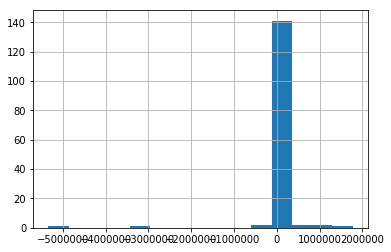

In [134]:
hist = df_1Yr_Diff['MD_Diff'].hist(bins=15)
df_1Yr_Diff['MD_Diff'].describe()
# MEMBERSHIP DUES:
# average change from old form to new form:  -$19,349.65
# median chang from old form to new form:    $0  

count    1.500000e+02
mean     1.827808e+05
std      8.304695e+05
min     -1.477048e+06
25%     -8.182000e+03
50%      0.000000e+00
75%      1.093498e+05
max      6.231128e+06
Name: GG_Diff, dtype: float64

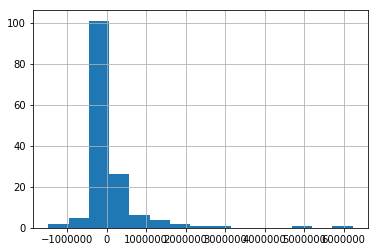

In [136]:
hist = df_1Yr_Diff['GG_Diff'].hist(bins=15)
df_1Yr_Diff['GG_Diff'].describe()
# GOVERNMENT GRANTS:
# average change from old form to new form:  $182,780.80
# median chang from old form to new form:    $0  

count    1.500000e+02
mean     3.889224e+05
std      2.433344e+06
min     -2.497545e+06
25%     -5.087875e+04
50%      3.161500e+03
75%      1.165458e+05
max      2.268273e+07
Name: SR_Diff, dtype: float64

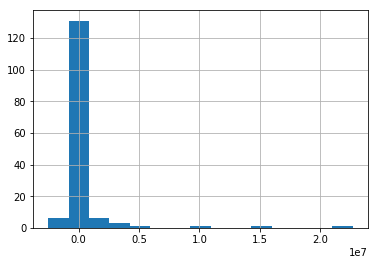

In [142]:
hist = df_1Yr_Diff['SR_Diff'].hist(bins=15)
df_1Yr_Diff['SR_Diff'].describe()
# SERVICE REVENUE:
# average change from old form to new form:  $388,922.40
# median chang from old form to new form:    $  3,161.50

count    1.500000e+02
mean     5.523535e+05
std      2.621780e+06
min     -5.339332e+06
25%     -8.414750e+04
50%      5.132350e+04
75%      4.347262e+05
max      2.268419e+07
Name: DonationDiff, dtype: float64

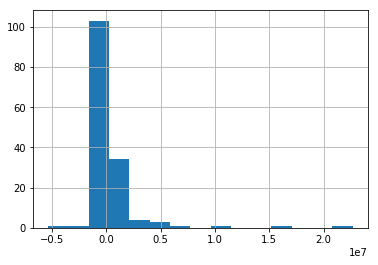

In [143]:
hist = df_1Yr_Diff['DonationDiff'].hist(bins=15)
df_1Yr_Diff['DonationDiff'].describe()
# TOTAL:
# average change from old form to new form:  $552,353.50
# median chang from old form to new form:    $ 51,323.50

In [157]:
#now lets check 2006 to 2007 (all old form)
df_06_TD = df_Old_TotalDonations[df_Old_TotalDonations['FiscalYearEnd'] == 2006]
df_07_TD = df_Old_TotalDonations[df_Old_TotalDonations['FiscalYearEnd'] == 2007]
#below df has all rows for 06-07 comparisons
df_0607_Diff = df_06_TD.merge(df_07_TD, on = 'EIN', suffixes = ('_06', '_07'))

In [158]:
#drop rows where 0 donations in 06 or 07 
df_0607_Diff = df_0607_Diff.loc[(df_0607_Diff['TotalDonations_06'] != 0) & (df_0607_Diff['TotalDonations_07'] != 0)]

In [160]:
#add columns for differences
df_0607_Diff['DonationDiff'] = df_0607_Diff['TotalDonations_07'] - df_0607_Diff['TotalDonations_06']
df_0607_Diff['MD_Diff'] = df_0607_Diff['membership_dues_07'] - df_0607_Diff['membership_dues_06']
df_0607_Diff['GG_Diff'] = df_0607_Diff['government_grants_07'] - df_0607_Diff['government_grants_06']
df_0607_Diff['SR_Diff'] = df_0607_Diff['service_revenue_07'] - df_0607_Diff['service_revenue_06']

count    1.689000e+03
mean     2.592685e+04
std      8.565766e+05
min     -5.480470e+06
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.224560e+07
Name: MD_Diff, dtype: float64

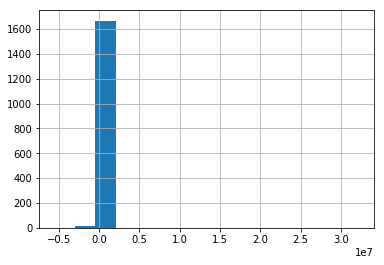

In [163]:
hist = df_0607_Diff['MD_Diff'].hist(bins=15)
df_0607_Diff['MD_Diff'].describe()
# MEMBERSHIP DUES:
# average change from 06 to 07:  $25,926.85
# median chang from 06 to 07:    $0

count    1.689000e+03
mean     4.210151e+04
std      9.986284e+05
min     -1.025810e+07
25%      0.000000e+00
50%      0.000000e+00
75%      2.152900e+04
max      1.672521e+07
Name: GG_Diff, dtype: float64

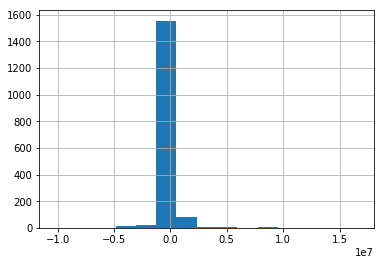

In [165]:
hist = df_0607_Diff['GG_Diff'].hist(bins=15)
df_0607_Diff['GG_Diff'].describe()
# GOVERNMENT GRANTS:
# average change from 06 to 07:  $42,101.51
# median chang from 06 to 07:    $0

count    1.689000e+03
mean     8.949532e+05
std      9.088704e+06
min     -1.941023e+07
25%     -9.199000e+03
50%      6.365000e+03
75%      1.692210e+05
max      2.861316e+08
Name: SR_Diff, dtype: float64

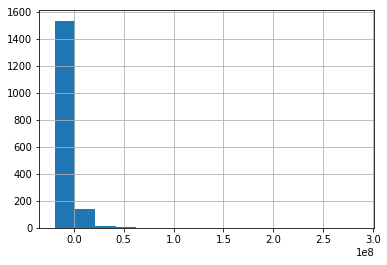

In [166]:
hist = df_0607_Diff['SR_Diff'].hist(bins=15)
df_0607_Diff['SR_Diff'].describe()
# SERVICE REVENUE:
# average change from 06 to 07:  $894,953.20
# median chang from 06 to 07:    $  6,365.00

count    1.689000e+03
mean     9.629816e+05
std      9.180311e+06
min     -1.941023e+07
25%     -4.881200e+04
50%      5.113400e+04
75%      2.809050e+05
max      2.861316e+08
Name: DonationDiff, dtype: float64

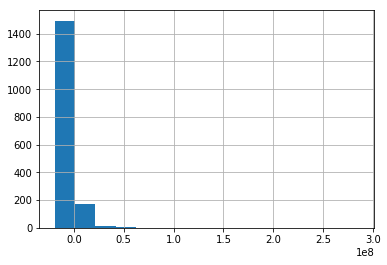

In [167]:
hist = df_0607_Diff['DonationDiff'].hist(bins=15)
df_0607_Diff['DonationDiff'].describe()
# TOTAL:
# average change from 06 to 07:  $962,981.60
# median chang from 06 to 07:    $ 51,134.00

In [ ]:
#now lets look at a scatter over time for each of the variables
df_Yearly_Donations = pd.concat([df_New_TotalDonations, df_Old_TotalDonations], ignore_index = True)

In [176]:
#drop where total donations are 0
df_Yearly_Donations = df_Yearly_Donations[df_Yearly_Donations['TotalDonations'] != 0]

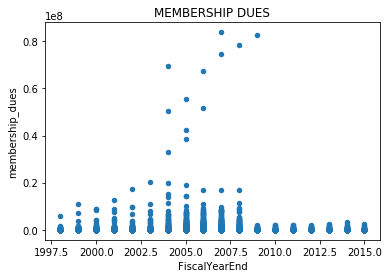

In [182]:
plt = df_Yearly_Donations.plot.scatter(x='FiscalYearEnd', y = 'membership_dues', title = 'MEMBERSHIP DUES')

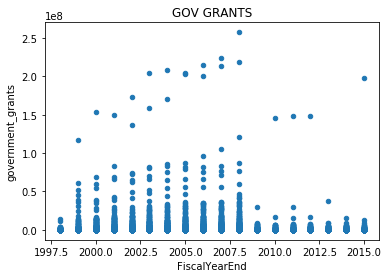

In [183]:
plt = df_Yearly_Donations.plot.scatter(x='FiscalYearEnd', y = 'government_grants', title = 'GOV GRANTS')

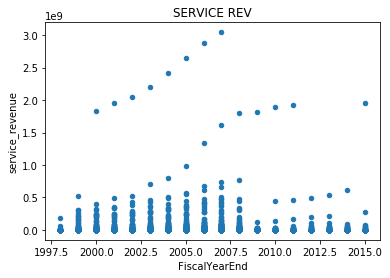

In [184]:
plt = df_Yearly_Donations.plot.scatter(x='FiscalYearEnd', y = 'service_revenue', title = 'SERVICE REV')

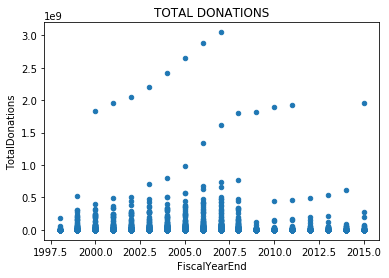

In [185]:
plt = df_Yearly_Donations.plot.scatter(x='FiscalYearEnd', y = 'TotalDonations', title = 'TOTAL DONATIONS')

In [187]:
df_Yearly_Donations['TotalDonations'].describe()

count    2.339700e+04
mean     6.307947e+06
std      6.184909e+07
min     -4.454380e+05
25%      1.061650e+05
50%      4.894270e+05
75%      1.757159e+06
max      3.048626e+09
Name: TotalDonations, dtype: float64

In [190]:
#only for EINs in both old and new below
#******************
df_Yearly_ON = df_Yearly_Donations[df_Yearly_Donations['EIN'].isin(df_TD_Diff['EIN'])]

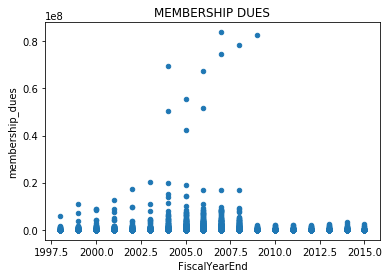

In [191]:
plt = df_Yearly_ON.plot.scatter(x='FiscalYearEnd', y = 'membership_dues', title = 'MEMBERSHIP DUES')

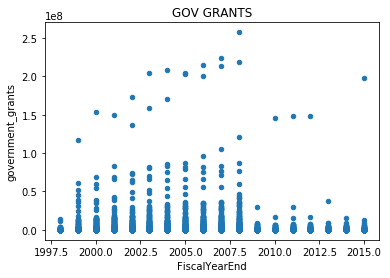

In [192]:
plt = df_Yearly_ON.plot.scatter(x='FiscalYearEnd', y = 'government_grants', title = 'GOV GRANTS')

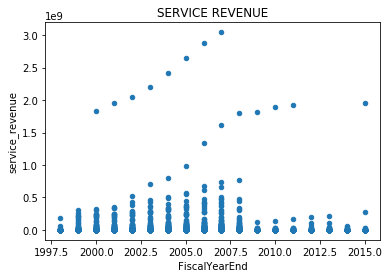

In [193]:
plt = df_Yearly_ON.plot.scatter(x='FiscalYearEnd', y = 'service_revenue', title = 'SERVICE REVENUE')

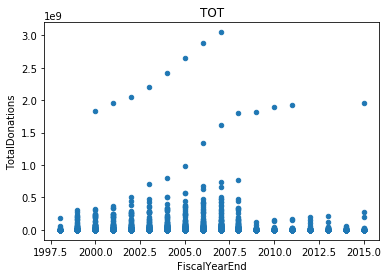

In [194]:
plt = df_Yearly_ON.plot.scatter(x='FiscalYearEnd', y = 'TotalDonations', title = 'TOT')

In [201]:
df_Yearly_ON['FiscalYearEnd'].value_counts()

2003    2051
2002    1960
2007    1849
2001    1831
2006    1750
2000    1693
2004    1642
2008    1466
2005    1300
1999     825
2012     332
2011     331
2013     306
2014     304
2010     228
2009     224
2015     204
1998     201
Name: FiscalYearEnd, dtype: int64

In [206]:
#now only EIns in old new and pcg
df_Yearly_PCG = df_Yearly_Donations[df_Yearly_Donations['EIN'].isin(df_PCG_All.merge(df_TD_Diff, on= 'EIN')['EIN'])]

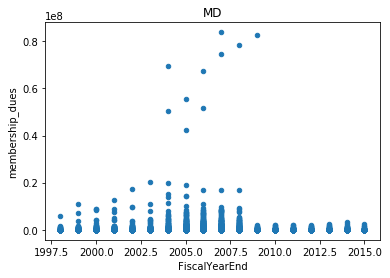

In [207]:
plt = df_Yearly_ON.plot.scatter(x='FiscalYearEnd', y = 'membership_dues', title = 'MD')